In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests

In [2]:
def readInDir(dirPath): #function will read in all files in a directory + append them to df -- have to download files and place in a directory first
    counter = 0
    for file in os.listdir(dirPath): #list all the files in specified directory, loop over them
        data = pd.read_csv('{0}/{1}'.format(dirPath,file)) #data contained from a singular file
        df = data.filter(['phot_g_mean_mag','parallax','bp_rp','parallax_over_error','teff_val'], axis=1) #filter out unnecessary things
        df = df.dropna() #drop NAN values
        if counter == 0: #initialize master DataFrame at first file
            masterDF = df
        else:
            masterDF = pd.concat([masterDF, df], axis=0) #add new df on subsequent loops to old one
        counter+=1
    return masterDF #after adding them all together spit out the result

titleString1 = "Color-magnitude diagram for 10 most recent (downloaded) Gaia files"
df1 = readInDir('/home/kirk/Documents/gradSchool/ASTR_3730/GAIA/') #local method of reading in downloaded files in this directory

In [3]:
def readFROM_THE_INTERNET(url,N,rand=False): #exciting way to generate plots without ever downloading the data!
    #special thanks to Patrick McCreery for showing me this way of web-scraping with Python!!!
    page = requests.get(url) #get the webpage
    soup = BeautifulSoup(page.text, parser='lxml') #parse the HTML of the webpage
    hrefs = [url + x.get('href') for x in soup.findAll('a')] #hrefs are what anchors each horizontal line, in this case the CSV files
    if rand == False:
        indices = [i for i in range(N)] #we will use this to just take the 1st N files
    else:
        indices = np.random.randint(len(hrefs),size=N) #generate a random href index N times, take N random files
    counter = 0
    for i in range(N):
        data = pd.read_csv(hrefs[indices[i]]) #read in the file from the INTERWEBS  
        df = data.filter(['phot_g_mean_mag','parallax','bp_rp','parallax_over_error','teff_val'], axis=1) #filter out unnecessary things
        df = df.dropna() #drop NAN values
        if counter == 0: #initialize master DataFrame at first file
            masterDF = df
        else:
            masterDF = pd.concat([masterDF, df], axis=0) #add new df on subsequent loops to old one
        counter+=1
    return masterDF #after adding them all together spit out the result

random = True; N = 10 #N = 100 takes a couple min, N = 10 < min
if random == True:
    titleString2 = "Color-magnitude diagram for {0} randomly selected Gaia files".format(N)
else:
    titleString2 = "Color-magnitude diagram for {0} most recent Gaia files".format(N)
  
df2 = readFROM_THE_INTERNET('http://cdn.gea.esac.esa.int/Gaia/gdr2/gaia_source/csv/',N,rand=random) #take N random/most recent files from the entirety of the archive

/home/kirk/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


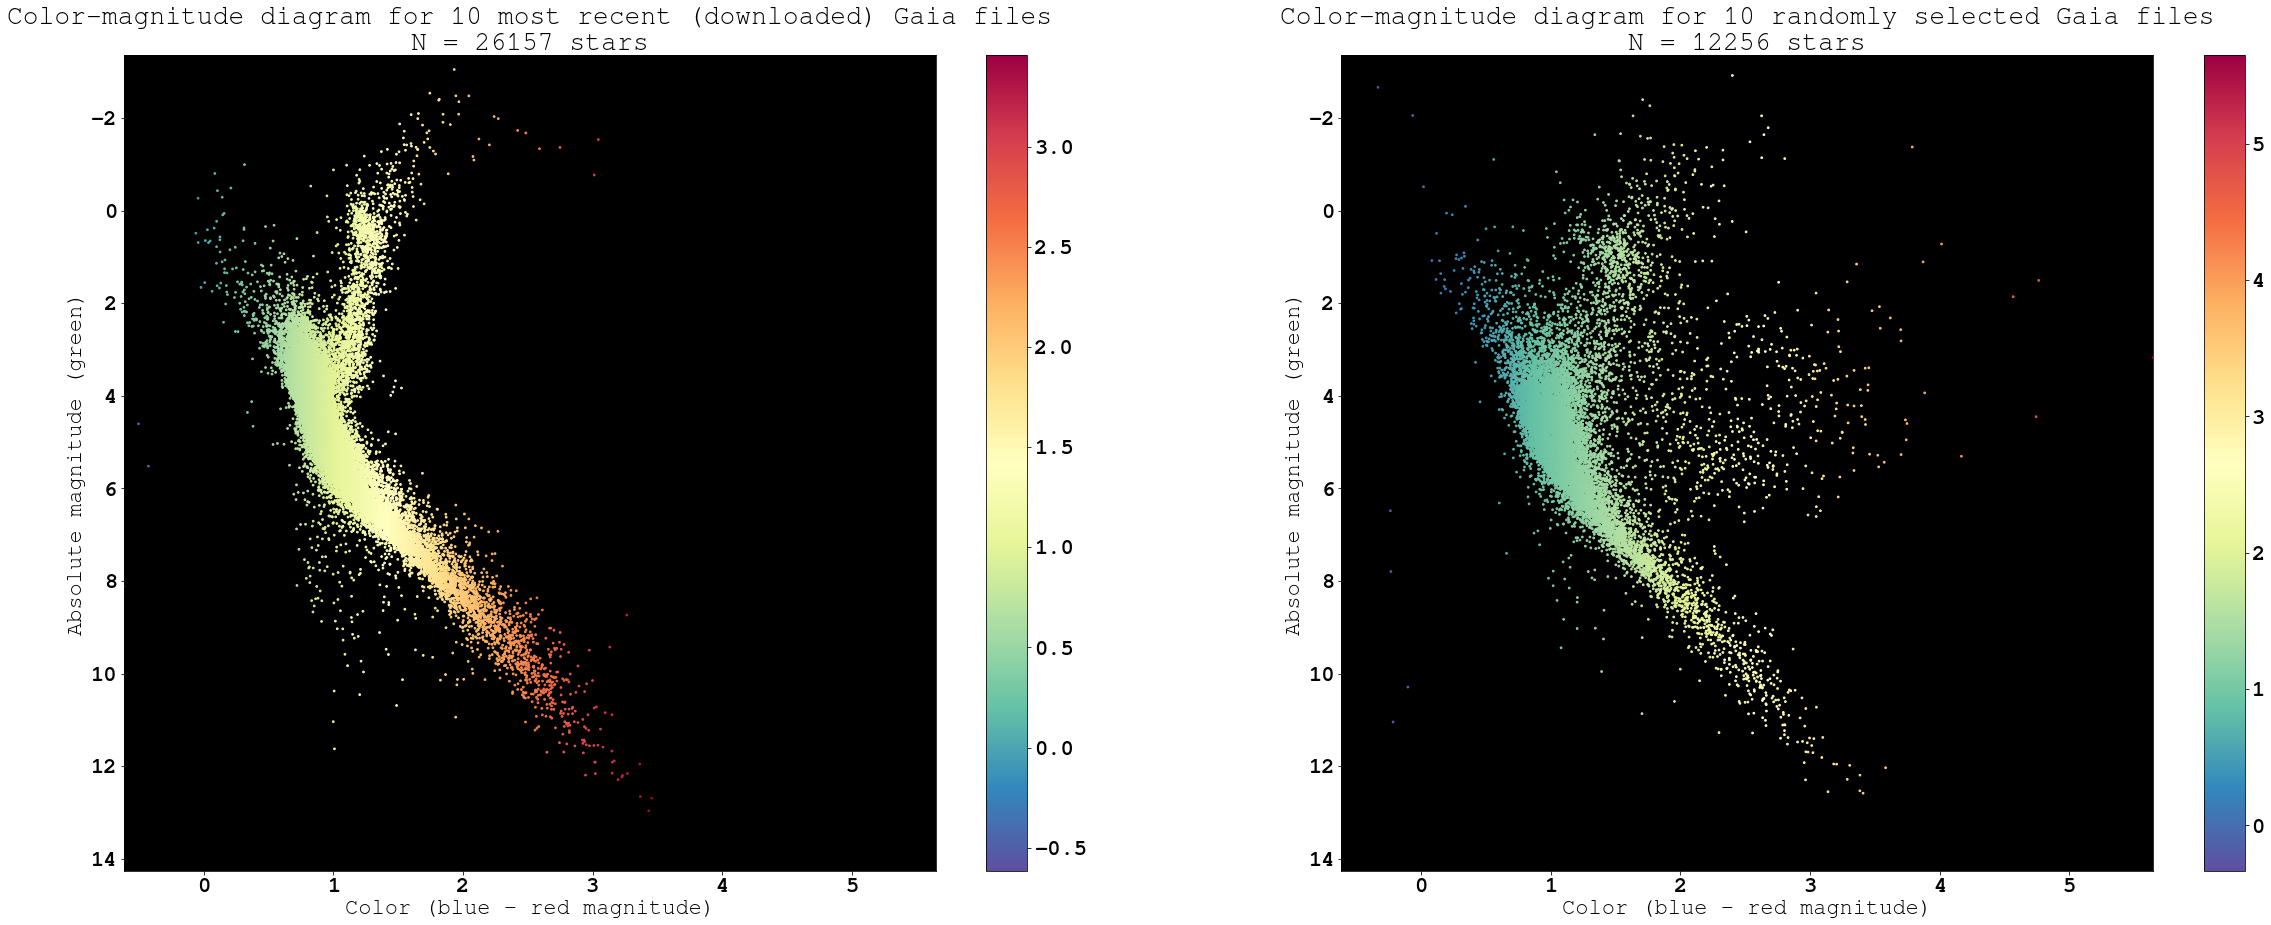

In [4]:
fig = plt.figure(1,figsize=(40,15)) #initialize figure
ax = fig.gca() #get current axes

distance1,distance2 = 1000/df1.parallax,1000/df2.parallax #mas -> as, pc
gmag_abs1,gmag_abs2 = df1.phot_g_mean_mag-5*(np.log10(distance1)-1),df2.phot_g_mean_mag-5*(np.log10(distance2)-1) #distance modulus
good1,good2 = df1.parallax_over_error>4,df2.parallax_over_error>4

limList = [[min(df1.bp_rp[good1]),max(df1.bp_rp[good1]),min(df2.bp_rp[good2]),max(df2.bp_rp[good2])],
         [max(gmag_abs1[good1])*1.1,min(gmag_abs1[good1])*1.1,max(gmag_abs2[good2])*1.1,min(gmag_abs2[good2])*1.1]]
globalXLim = [min(limList[0]),max(limList[0])]
globalYLim = [max(limList[1]),min(limList[1])]
#get global limits so both plots have same axes   

font = {'family' : 'FreeMono',
        'weight' : 'bold',
        'size'   : 22}	
plt.rc('font', **font) #set all plot font attributes according to above
plt.rcParams['axes.facecolor'] = 'black' #change plot interior to black
plt.subplot(1,2,1) #first subplot
plt.scatter(df1.bp_rp[good1],gmag_abs1[good1],s=3,c=df1.bp_rp[good1],cmap="Spectral_r") #plot only the good points with nice color map
plt.colorbar() #add the colorbar
plt.xlim(globalXLim)
plt.ylim(globalYLim) #reverse the y-axis, 10% padding
plt.title(titleString1+"\nN = {0} stars".format(len(gmag_abs1[good1])))
plt.xlabel("Color (blue - red magnitude)")
plt.ylabel("Absolute magnitude (green)")

plt.subplot(1,2,2) #second subplot
plt.scatter(df2.bp_rp[good2],gmag_abs2[good2],s=3,c=df2.bp_rp[good2],cmap="Spectral_r") #plot only the good points with nice color map
plt.colorbar() #add the colorbar
plt.xlim(globalXLim)
plt.ylim(globalYLim) #reverse the y-axis, 10% padding
plt.title(titleString2+"\nN = {0} stars".format(len(gmag_abs2[good2])))
plt.xlabel("Color (blue - red magnitude)")
plt.ylabel("Absolute magnitude (green)")
plt.savefig("colorMagExampleKirk.png",dpi=300) #save as high-res png
plt.show()